In [39]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import numpy as np
import cv2
import time
import sys
import re
from copy import deepcopy
from collections import defaultdict
from itertools import islice
from tqdm import tqdm_notebook
from time import time
from easydict import EasyDict
from IPython.core.debugger import set_trace
from matplotlib import pyplot as plt
from warnings import filterwarnings

import torch
from torch import nn
import torch.nn.functional as F
from torch import autograd
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader

from mvn.datasets.human36m import Human36MMultiViewDataset
from mvn.utils.img import image_batch_to_numpy, denormalize_image, to_numpy 
from mvn.utils.multiview import project_3d_points_to_image_plane_without_distortion
from mvn.utils.vis import draw_2d_pose, display_pose, CONNECTIVITY_DICT
from mvn.utils.op import get_coord_volumes, integrate_tensor_3d_with_coordinates, unproject_heatmaps, compose
from mvn.utils import cfg

from mvn.datasets import utils as dataset_utils

from train_decomposition import setup_human36m_dataloaders

%matplotlib inline

device = 'cuda:0' #torch.cuda.current_device()

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Calculate

In [96]:
experiment_path = '../logs/decomposition_50/h36_sv32_dist_Image2Lixel-bare-TT-rank20-lr1e-3-imsize256_ResNet-50-lr1e-4_bs1-1_VCE-1_MAE-1_coord_vol_SoftMax@27.10.2020-18:19:18'
# experiment_path = '../logs/decomposition_50/h36_sv32_dist_Image2Lixel-bare-TT-rank5-lr1e-3-imsize256_ResNet-50-lr1e-4_bs1-1_VCE-1_MAE-1_coord_vol_SoftMax@23.10.2020-21:05:07'

config = cfg.load_config(os.path.join(experiment_path, 'config.yaml'))
num_joints = config.model.backbone.num_joints

In [97]:
from mvn.models.image2lixel import I2LModel
model = I2LModel(config, device=device).to(device)

Loading pretrained weights from: ./data/pose_resnet_4.5_pixels_human36m.pth
Successfully loaded pretrained weights for backbone
pose_net:  28.16M
backbone:  23.51M


In [98]:
state_dict = torch.load(os.path.join(experiment_path, 'checkpoints/weights.pth'))['model_state']
model.load_state_dict(state_dict, strict=True)

<All keys matched successfully>

# Forward

In [99]:
train_loader, val_loader, _ = setup_human36m_dataloaders(config, is_train=True, distributed_train=False)

for batch in train_loader:
    break

(images_batch, 
keypoints_3d_gt, 
keypoints_3d_validity_gt, 
proj_matricies_batch) = dataset_utils.prepare_batch(batch, device)

heatmaps_pred, keypoints_2d_pred, cuboids_pred, base_points_pred = None, None, None, None
torch.cuda.empty_cache()

In [100]:
self = model

In [101]:
device = images_batch.device
batch_size, dt = images_batch.shape[:2]
image_shape = images_batch.shape[-2:]

if self.pelvis_type == 'gt':
    tri_keypoints_3d = torch.from_numpy(np.array(batch['keypoints_3d'])).type(torch.float).to(device)
else:
    raise RuntimeError('In absence of precalculated pelvis or gt pelvis, self.use_volumetric_pelvis should be True') 

# posenet forward
_, _, _, _, pose_img_feat, shared_img_feat = self.backbone(images_batch.view(-1, 3, *image_shape))
return_only_xyz = self.return_coords_meshnet and self.return_coords_posenet
coordinates = get_coord_volumes(self.kind, 
                                    self.training, 
                                    self.rotation,
                                    self.cuboid_side, 
                                    self.volume_size, 
                                    self.device, 
                                    keypoints=tri_keypoints_3d,
                                    batch_size=batch_size,
                                    dt=None, 
                                    return_only_xyz=return_only_xyz, 
                                    max_rotation_angle=np.pi/4 #2 * np.pi
                                    )

base_points = tri_keypoints_3d[..., 6, :3]
joint_coord_img = self.pose_net(pose_img_feat, coordinates)
volumes_pred = None
if not return_only_xyz:
    coord_volumes = coordinates[0]

In [102]:
coordinates[0].shape, coordinates[1], coordinates[-1].shape

(torch.Size([1, 32, 32, 32, 3]), None, torch.Size([1, 3]))

In [103]:
return_only_xyz, tri_keypoints_3d.shape

(False, torch.Size([1, 17, 4]))

In [104]:
self.pose_net.joint_independent

True

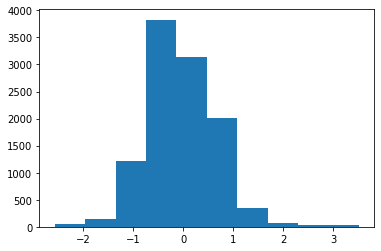

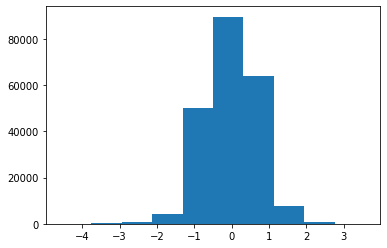

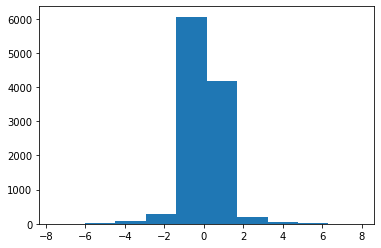

In [105]:
for j in joint_coord_img: plt.figure(); plt.hist(to_numpy(j).flatten())

In [106]:
print (self.training, 
        self.rotation,
        self.cuboid_side, 
        self.volume_size, 
        self.device)

True False 2500 32 cuda:0


In [107]:
not self.return_coords_posenet, self.volume_multiplier, self.volume_softmax

(True, 1.0, True)

In [108]:
if not self.return_coords_posenet:
    volumes = compose(None, joint_coord_img, 'tt', joint_independent=self.joint_independent_posenet)
    joint_coord_img, volumes_pred = integrate_tensor_3d_with_coordinates(volumes * self.volume_multiplier,
                                                                            coord_volumes,
                                                                            softmax=self.volume_softmax)

In [120]:
volumes.max()

tensor(5508.6338, device='cuda:0', grad_fn=<MaxBackward1>)

In [119]:
torch.exp(volumes).min(), torch.exp(volumes).max()

(tensor(0., device='cuda:0', grad_fn=<MinBackward1>),
 tensor(inf, device='cuda:0', grad_fn=<MaxBackward1>))

ValueError: supplied range of [0.0, inf] is not finite

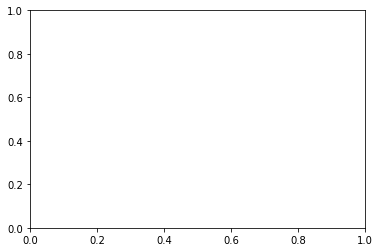

In [117]:
plt.hist(to_numpy(torch.exp(volumes)).flatten(), bins=100)
plt.yscale('log')
plt.show()

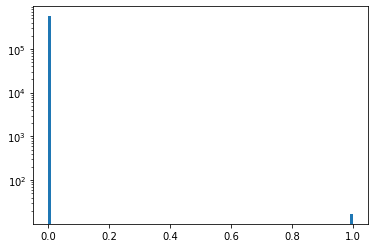

In [110]:
# after softmax (used in model)
plt.hist(to_numpy(volumes_pred).flatten(), bins=100)
plt.yscale('log')
plt.show()

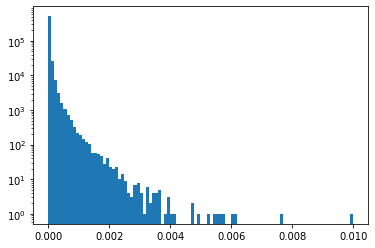

In [111]:
# if we just normalize it
volumes_norm = F.relu(volumes)
volumes_norm = volumes_norm / volumes_norm.view(batch_size, 17, -1).sum(-1).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
plt.hist(to_numpy(volumes_norm).flatten(), bins=100)
plt.yscale('log')
plt.show()

In [52]:
volumes_pred.sum()

tensor(17., device='cuda:0', grad_fn=<SumBackward0>)

In [46]:
joint_coord_img

tensor([[[-1464.4119,  -497.0532,  1374.6631],
         [-1786.9926, -1142.2145,  1455.3083],
         [-1061.1860,  -497.0532,  1374.6631],
         [-1867.6377, -1706.7306,  1374.6631],
         [ -738.6055,  -980.9241,  1213.3728],
         [ -335.3796,  -174.4725,  1213.3728],
         [-1464.4119, -1545.4402,  1374.6631],
         [  148.4912, -1142.2145,  1455.3083],
         [ -174.0894, -1787.3757,  1616.5986],
         [ -335.3796, -1787.3757,  1374.6631],
         [-1867.6377, -1706.7306,  1455.3083],
         [ -577.3152, -1787.3757,  1052.0825],
         [-2028.9280, -1626.0854,  1455.3083],
         [ -980.5409,  -738.9886,  1374.6631],
         [ -335.3796,  -497.0532,  1374.6631],
         [  -93.4442, -1948.6660,  1374.6631],
         [ -174.0894, -1142.2145,  1455.3083]]], device='cuda:0',
       grad_fn=<ViewBackward>)

In [14]:
if self.use_meshnet:
    joint_heatmap = self.make_gaussian_heatmap(joint_coord_img, self.sigma)

    # interpolate - workaround to match `shared_img_feat` spatial dim
    joint_heatmap = F.interpolate(joint_heatmap, (64,64,64))
    shared_img_feat = self.pose2feat(shared_img_feat, joint_heatmap) #[1, 64, 64, 64])

    # meshnet forward
    _, _, _, _, mesh_img_feat, _ = self.mesh_backbone(shared_img_feat)
    mesh_coord_img = self.mesh_net(mesh_img_feat, coordinates)

    if self.use_mesh_model:    
        # joint coordinate outputs from mesh coordinates
        joint_img_from_mesh = torch.bmm(torch.from_numpy(self.joint_regressor).cuda()[None,:,:].repeat(mesh_coord_img.shape[0],1,1), mesh_coord_img)
        joint_coord_img = joint_img_from_mesh
    else:
        joint_coord_img = mesh_coord_img

        if not self.return_coords_meshnet:
            volumes = compose(None, joint_coord_img, 'tt', joint_independent=self.joint_independent_meshnet)
            joint_coord_img, volumes_pred = integrate_tensor_3d_with_coordinates(volumes * self.volume_multiplier,
                                                                               coord_volumes,
                                                                               softmax=self.volume_softmax)